In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', -1)

# Text mining
In this work I'm going to analyse the project names of KickStarter projects.

**I want to know if there is a correlation between the success of a project and the words used in its name.**

## Data preparation
In this work I'm going to analyse the project names of several KickStarter projects.
Kaggle: https://www.kaggle.com/kemical/kickstarter-projects/data

In [3]:
#read data
df = pd.read_csv('data_textmining.csv', index_col=0, encoding='utf-8-sig')

In [4]:
# create a copy and drop no related columns
df = df.drop([ 'currency', 'deadline', 'goal',
       'launched', 'pledged', 'state', 'backers', 'date_diff', 'rtdate', 'rate', 'goal_usd', 'pledged_usd'], axis=1)
dfname = df.copy()

In [5]:
dfname.head()

,name,category,main_category,country,successful
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GB,0
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,US,0
2,Where is Hank?,Narrative Film,Film & Video,US,0
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,US,0
4,Community Film Project: The Art of Neighborhood Filmmaking,Film & Video,Film & Video,US,0


In [6]:
# make sure all names are string
dfname['name'] = dfname.name.astype(str)

# there are 23105  projects with (canceled) in the name
pattern = '\(canceled\)'
dfname['name'] = dfname.name.str.replace(pattern, '', n=1, case=False)

# there are 1060  projects with (suspended) in the name
pattern = '\(suspended\)'
dfname['name'] = dfname.name.str.replace(pattern, '', n=1, case=False)

#remove rare characters 
pattern = '[^A-Za-z0-9!? ]'
dfname['name'] = dfname.name.str.replace(pattern, '')

pattern = '\(\)'
dfname['name'] = dfname.name.str.replace(pattern, '')

#remove excess whitespace
for i in range(8):
    pattern = '  '
    dfname['name'] = dfname.name.str.replace(pattern, ' ')

In [7]:
# create new feature: name length
dfname['name_len'] = dfname.name.str.len()

# convert all to lowercase before split
dfname['name_low'] = dfname.name.str.lower()

# get rid of ? ! before split
pattern = '[!?]'
dfname['name_low'] = dfname.name_low.str.replace(pattern, '')

# drop empty names
dfname = dfname.drop(dfname[dfname.name_len == 0].index, axis=0)
dfname = dfname.drop(dfname[dfname.name == ' '].index, axis=0) 

# split each name by whitespace creating a list with words
dfname['name_words']  = dfname.name_low.str.strip().str.split('[\s]')

# create new feature: number of words in each name
dfname['number_words']  =  dfname.name_words.str.len()

In [8]:
dfname.name_words.isnull().sum()

0

In [9]:
dfname.head()

,name,category,main_category,country,successful,name_len,name_low,name_words,number_words
0,The Songs of Adelaide Abullah,Poetry,Publishing,GB,0,29,the songs of adelaide abullah,"[the, songs, of, adelaide, abullah]",5
1,Greeting From Earth ZGAC Arts Capsule For ET,Narrative Film,Film & Video,US,0,44,greeting from earth zgac arts capsule for et,"[greeting, from, earth, zgac, arts, capsule, for, et]",8
2,Where is Hank?,Narrative Film,Film & Video,US,0,14,where is hank,"[where, is, hank]",3
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,US,0,49,toshicapital rekordz needs help to complete album,"[toshicapital, rekordz, needs, help, to, complete, album]",7
4,Community Film Project The Art of Neighborhood Filmmaking,Film & Video,Film & Video,US,0,57,community film project the art of neighborhood filmmaking,"[community, film, project, the, art, of, neighborhood, filmmaking]",8


In [98]:
dfname.to_csv('dfname.csv', encoding='utf-8-sig')

##  Keywords
### There are 15 main categories and the success rate is different between them.
** I want to find the most used words in successful projects in each category **

In [29]:
# create a safe copy
dfname2 = dfname.copy()

In [79]:
dfname2.main_category.value_counts()

Film & Video    63582
Music           51917
Publishing      39873
Games           35231
Technology      32569
Design          30069
Art             28151
Food            24602
Fashion         22815
Theater         10912
Comics          10819
Photography     10778
Crafts          8809 
Journalism      4755 
Dance           3768 
Name: main_category, dtype: int64

### Category: Music

In [33]:
dfmusic = dfname2[dfname2.main_category == 'Music']
dfmusic.head()

,name,category,main_category,country,successful,name_len,name_low,name_words,number_words
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,US,0,49,toshicapital rekordz needs help to complete album,"[toshicapital, rekordz, needs, help, to, complete, album]",7
11,Lisa Lim New CD!,Indie Rock,Music,US,1,16,lisa lim new cd,"[lisa, lim, new, cd]",4
18,Mike Coreys Darkness Light Album,Music,Music,US,1,32,mike coreys darkness light album,"[mike, coreys, darkness, light, album]",5
25,Matt Cavenaugh Jenny Powers make their 1st album!,Music,Music,US,1,50,matt cavenaugh jenny powers make their 1st album,"[matt, cavenaugh, jenny, powers, make, their, 1st, album]",8
34,Chris Eger Band New Nashville Record!,Music,Music,US,1,37,chris eger band new nashville record,"[chris, eger, band, new, nashville, record]",6


In [36]:
def splitwords(table):
    rows= list()
    for row in table[['successful', 'name_words']].iterrows():
        r = row[1]
        for word in r.name_words:
            rows.append((r.successful, word))
        
    words = pd.DataFrame(rows, columns=['successful', 'word'])
    return words

In [38]:
music_words = splitwords(dfmusic)
music_words.head()

,successful,word
0,0,toshicapital
1,0,rekordz
2,0,needs
3,0,help
4,0,to


In [39]:
words = music_words.copy()

In [40]:
# drop empty words
words = words.drop(words[words.word == ''].index, axis=0)

In [41]:
 # pivot table
count_words = words.pivot_table(index = 'word', columns='successful',aggfunc=np.size)

In [42]:
count_words.head()

successful,0,1
word,,
0,4.0,2.0
000,2.0,NaN
00001,2.0,NaN
001,6.0,2.0
002,2.0,2.0


In [43]:
count_words = count_words.sort_values(1, ascending=False)

In [44]:
# save to csv for further analysis
#count_words.to_csv('count_words_music.csv', encoding='utf-8-sig')

In [45]:
# create new features
n_successful = len(dfname[dfname.successful == 1])

n_failed = len(dfname[dfname.successful == 0])

count_words['prop_successful'] = count_words[1] / n_successful

count_words['prop_failed'] = count_words[0] / n_failed

count_words['diff'] = count_words['prop_successful'] - count_words['prop_failed']

# which words are more used in successful projects than in failed projects?
sorted_bydiff = count_words.sort_values(by='diff', ascending=False)
sorted_bydiff[:10]
#the is a connecting word, gives more information about a project

successful,0,1,prop_successful,prop_failed,diff
word,,,,,
album,11360.0,16262.0,0.118664,0.047018,0.071646
the,13324.0,15304.0,0.111674,0.055147,0.056527
new,4626.0,8412.0,0.061383,0.019147,0.042236
debut,3520.0,5864.0,0.042790,0.014569,0.028221
ep,4024.0,5654.0,0.041257,0.016655,0.024602
a,5170.0,5988.0,0.043695,0.021398,0.022296
record,1756.0,3270.0,0.023861,0.007268,0.016593
and,3554.0,3884.0,0.028342,0.014710,0.013632
of,4516.0,4418.0,0.032238,0.018691,0.013547


In [52]:
# drop some of the most common words in English (source: https://simple.wikipedia.org/wiki/Most_common_words_in_English)
most10 = ['the', 'be', 'to', 'of', 'and', 'a', 'in', 'that', 'have', 'I', 'by', 'at', 'an', 'from', '1', '2', 'about', 
          'is', 'on', '2014', '3', '2013', 'their', 'for']
most100diff = sorted_bydiff[:111]

for row in most100diff.iterrows():
    if row[0] in most10:
        most100diff = most100diff.drop(row[0])

most100diff.head()

successful,0,1,prop_successful,prop_failed,diff
word,,,,,
album,11360.0,16262.0,0.118664,0.047018,0.071646
new,4626.0,8412.0,0.061383,0.019147,0.042236
debut,3520.0,5864.0,0.042790,0.014569,0.028221
ep,4024.0,5654.0,0.041257,0.016655,0.024602
record,1756.0,3270.0,0.023861,0.007268,0.016593


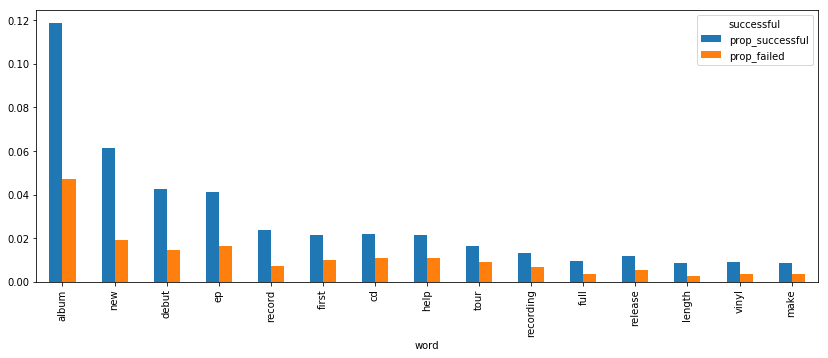

In [82]:
plt.rc('figure', figsize=(14, 5))
most15diff = most100diff[['prop_successful', 'prop_failed']][:15]
most15diff.plot.bar();

We can see that projects with names containing words related to music are more successful.

In [83]:
most15diff.index

Index(['album', 'new', 'debut', 'ep', 'record', 'first', 'cd', 'help', 'tour',
       'recording', 'full', 'release', 'length', 'vinyl', 'make'],
      dtype='object', name='word')

# Analysis

In [84]:
dfkey = dfmusic.copy()

In [85]:
dfkey['contain_kw'] = np.zeros(len(dfkey))
dfkey.head()

,name,category,main_category,country,successful,name_len,name_low,name_words,number_words,contain_kw
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,US,0,49,toshicapital rekordz needs help to complete album,"[toshicapital, rekordz, needs, help, to, complete, album]",7,0.0
11,Lisa Lim New CD!,Indie Rock,Music,US,1,16,lisa lim new cd,"[lisa, lim, new, cd]",4,0.0
18,Mike Coreys Darkness Light Album,Music,Music,US,1,32,mike coreys darkness light album,"[mike, coreys, darkness, light, album]",5,0.0
25,Matt Cavenaugh Jenny Powers make their 1st album!,Music,Music,US,1,50,matt cavenaugh jenny powers make their 1st album,"[matt, cavenaugh, jenny, powers, make, their, 1st, album]",8,0.0
34,Chris Eger Band New Nashville Record!,Music,Music,US,1,37,chris eger band new nashville record,"[chris, eger, band, new, nashville, record]",6,0.0


In [96]:
# define keywords to analize
keywords = ['album', 'new', 'debut', 'ep', 'record', 'first', 'cd', 'help', 'tour',
       'recording', 'full', 'release', 'length', 'vinyl', 'make']

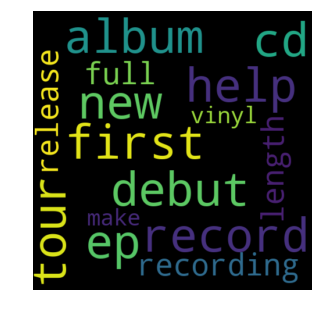

In [97]:
# Libraries
from wordcloud import WordCloud
# Create the wordcloud object
key = ' '.join(keywords)
wordcloud = WordCloud(width=480, height=480, max_font_size=80, min_font_size=10).generate(key)
 
# Display the generated image:
plt.rc('figure', figsize=(5, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)

In [87]:
for word in keywords:
    dfkey['contain_kw'] = np.where(dfkey.name_low.str.contains(word),1 ,dfkey['contain_kw'])

dfkey.contain_kw = dfkey.contain_kw.astype(int)

In [88]:
dfkey[dfkey.contain_kw == 1] 

,name,category,main_category,country,successful,name_len,name_low,name_words,number_words,contain_kw
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,US,0,49,toshicapital rekordz needs help to complete album,"[toshicapital, rekordz, needs, help, to, complete, album]",7,1
11,Lisa Lim New CD!,Indie Rock,Music,US,1,16,lisa lim new cd,"[lisa, lim, new, cd]",4,1
18,Mike Coreys Darkness Light Album,Music,Music,US,1,32,mike coreys darkness light album,"[mike, coreys, darkness, light, album]",5,1
25,Matt Cavenaugh Jenny Powers make their 1st album!,Music,Music,US,1,50,matt cavenaugh jenny powers make their 1st album,"[matt, cavenaugh, jenny, powers, make, their, 1st, album]",8,1
34,Chris Eger Band New Nashville Record!,Music,Music,US,1,37,chris eger band new nashville record,"[chris, eger, band, new, nashville, record]",6,1
36,Arrows Sound Debut Album,Indie Rock,Music,US,1,24,arrows sound debut album,"[arrows, sound, debut, album]",4,1
39,Help Scott Reynolds Make a New Record!,Indie Rock,Music,US,1,38,help scott reynolds make a new record,"[help, scott, reynolds, make, a, new, record]",7,1
72,My Future Just Passed Debut CD Jazz Trio,Jazz,Music,US,1,40,my future just passed debut cd jazz trio,"[my, future, just, passed, debut, cd, jazz, trio]",8,1
83,Spiral Electric Skylab Recording,Rock,Music,US,1,32,spiral electric skylab recording,"[spiral, electric, skylab, recording]",4,1
93,Glyscian Debut Album Recording,Rock,Music,US,0,31,glyscian debut album recording,"[glyscian, debut, album, recording]",4,1


## Associations between binary variables
Successful and Contain keyword are binary variables. We want to see if there is a correlation between them.

In [63]:
# import libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.mosaicplot import mosaic

C:\Users\Jimena\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [89]:
# create a table with only two binary variables
df = dfkey[['successful', 'contain_kw']]
df.head()

# Make a crosstab
crosstabkw = pd.crosstab(index= df['contain_kw'], 
                         columns=df["successful"] )
                         
crosstabkw = crosstabkw.rename(index={0: 'No_KW', 1:'Yes_KW'} , columns= {1: 'Successful', 0:'Failed'})
crosstabkw

successful,Failed,Successful
contain_kw,,
No_KW,12648,8059
Yes_KW,13706,17504


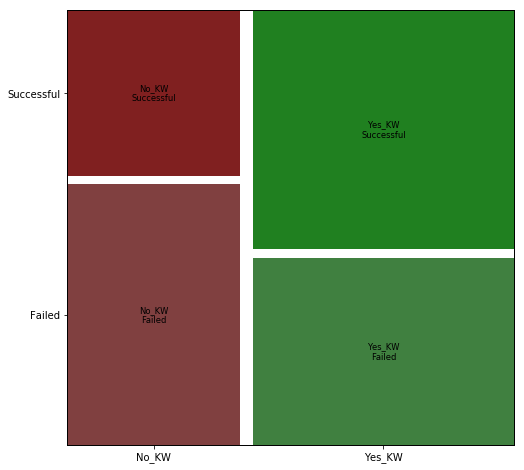

In [94]:
# create a mosaic graph 
plt.rc('figure', figsize=(8, 8))
mosaic(crosstabkw.stack(),gap=0.03 );

## Testing No-Correlation

An assertion that two variables are not related is based on a concept in statistics called the null hypothesis.

The null hypothesis in this case would state, **“There is no relationship between Keyword in a project name and Success of a project.”**

In a test for independence between Successful and Contain Keyword , if there is no relationship, then the null hypothesis is true. The alternative hypothesis is that the variables are in fact related – they are dependent, rather than independent.

The association between binary numbers can be interpreted the same way as the Pearson Correlation r. In fact, phi is a shortcut method for computing r.

In [95]:
import scipy.stats as stats
x = df.contain_kw
y = df.successful
stats.pearsonr(x, y)

(0.16812402285571504, 0.0)

**The p-value is 0 so we can reject the null hypothesis, the keywords in the names are related with the success of the projects.**

## Correlation between Keywords and Success is aprox 17%